<a href="https://colab.research.google.com/github/paraxioms/NotebookStored/blob/main/Assessment2_ClassificationOfWaterReactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assessment 2: Classification of Pressurised Water Reactor Status 

To save time/space and to avoid repition we have combined the code and the report into this notebook. The markdown cells contain the text previously in the report.

## Task 1 - Description of Distributed Learning Big Data Ecosystem 

Dealing with big data is a difficult task thats requires a distributed learning environment/ecosystem. 

Distributed file systems such as HDFS are essential for big data. They allow files on the file system to be accessed from multiple different hosts/computers. This makes it possible for people to share files and to access files stored somewhere else. Apache owns HDFS an example of a distributed file system, written in Java.

A resource manager and scheduler is also essential when working with big data. Applications on distribute learning ecosystems such as Spark run as independent sets of processes on a cluster, for this to work effectively a manager is needed to allocate resources across applications.

When thinking of Big Data we consider its characteristics. The main three being Voume, Velocity and Variety. Voume refers to the size and quantity of the data, velocity refers to the processing speed of the data and variety refers to all the different possible data formats that exist. Other big data characteristics include Value and Veracity. Value refers to what can be gained from making use of the data and veracity refers to the data quality. 

Fault tolerance and resiliance is very important in a distributed environment, if one processes fails in a cluster it shouldn't result in the failure of the whole cluster itself. Big data ecosystems should make use of fault tolerance clusters. As well as this the storage of the data is important, as it is located in several places it is important to use resisilient distributed datasets that can be automatically rebuilt in the event of failure.

A data lake is a repositary stored in its raw format, where data can be collected/organised without having to have the data structured. This data can then be used later to perform analysis/visualisations etc. This makes it easier to harness the power of big data, without having to worry and plan how the data is organised/stricuted. 

Apache Spark is a cluster computing system, that has the features in place to be act as a big data ecosystem. 

Apache Hive is a data warehouse that allows big data in distributed storage to be read, written and managed using SQL.

SparkML and PySpark are packages used in Spark which provide APIs that allow machine learning pipelines to be used and created, as well as other data science related analysis.

Spark SQL provides data frames and acts as a distrubuted SQL query engine. It is well integrated with SparkML and other Spark packages providing the essential tools required to work with the data.

Docker containers such as Kubernetes allow the user to organise applications into containers groups which are then run by using the Docker engine. This is responsible for running the whole application correctly.

Together these parts are used to make a distributed learning ecosystem.





## Task 2 - Develop distributed models in Apache spark to classify nuclear reactors 

### Subtask 1

We begin by creating an apache spark environment

In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz

In [ ]:
!tar xf spark-2.4.5-bin-hadoop2.7.tgz

In [ ]:
!pip install -q findspark


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

In [ ]:
import os
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init()


In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Learning_Spark") \
    .getOrCreate()

In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer #I believe this is similar to a label encoder
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler

#from pyspark import SparkContext
from pyspark.mllib.evaluation import MulticlassMetrics

import seaborn as sns
#import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#sc = SparkContext(appName="BinaryClassification")

In [ ]:
from google.colab import files
files.upload()

In [ ]:
data = spark.read.csv('DMV_CS551G_Assignment 2-dataset-nuclear_plants.csv',inferSchema=True, header=True)

In [ ]:
data.count(), len(data.columns)

(996, 13)

In [ ]:
data.printSchema()

root
 |-- Status: string (nullable = true)
 |-- Power_range_sensor_1: double (nullable = true)
 |-- Power_range_sensor_2: double (nullable = true)
 |-- Power_range_sensor_3 : double (nullable = true)
 |-- Power_range_sensor_4: double (nullable = true)
 |-- Pressure _sensor_1: double (nullable = true)
 |-- Pressure _sensor_2: double (nullable = true)
 |-- Pressure _sensor_3: double (nullable = true)
 |-- Pressure _sensor_4: double (nullable = true)
 |-- Vibration_sensor_1: double (nullable = true)
 |-- Vibration_sensor_2: double (nullable = true)
 |-- Vibration_sensor_3: double (nullable = true)
 |-- Vibration_sensor_4: double (nullable = true)



In [ ]:
data.show(5)

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|Normal|        

In [ ]:
#targets = data.select("Status")
#targets.show(5)

In [ ]:
df = data.drop("Status")
df.show(5)

+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|             6.048|           14.4659|            21.648|           15.3429|            1.2186|
|              4.4284|              0.9073| 

Below we provide the summary table required for this subtask. We can see that there are no missing values from the counts.

In [ ]:
df.summary().show()

+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|
+-------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|                 996|                 996|                  996|                 996|               996|               996|               996|               996|               996|               996|               996|               996|
|   mean|  4

### Subtask 2

We provide the two graphs required for this subtask below.

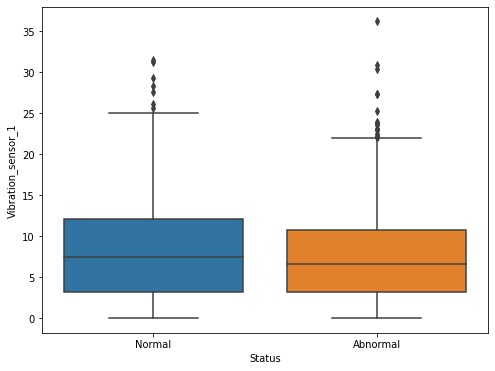

In [ ]:
f, ax = plt.subplots(figsize=(8, 6));
sns.boxplot(x=data.toPandas()['Status'], y=data.toPandas()["Vibration_sensor_1"]);

From this graph we can see the distribution of the sensor measurements for the two classes. We can see the median, quartiles potential outliers and the maximum and minimum value. We can see there is a difference between normal and abnormal but honestly not very much. The normal box plot has a higher range and inter-quartile range, the abnormal box plot has more outliers on the upper end. I do not think vibration_sensor_1 is a good indicator on its own, others sensor measurements have a much more noticeable difference.

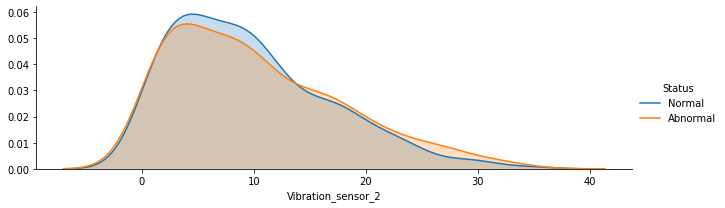

In [ ]:
f = sns.FacetGrid(data.toPandas(), hue = "Status", aspect=3 );
f.map(sns.kdeplot, "Vibration_sensor_2", shade= True );
f.add_legend();

From the density plot we can see the kernel density estimate of the two classes, showing how their distributions differ. In my opinion this is more useful than the box plot, as it gives a more detailed look into the data dsitribution. It's a smoothed version of a histogram, where the higher the y axis the higher the frequency of that measurement value.

### Subtask 3

Logistic Regression is a model used for classificaiton. It is similar to linear regression in some ways, with the main difference being that it uses the sigmoid function to map a continuos input to a value between 0 and 1, which can then in turn be mapped to the class 0 or 1, depending on whether it is above or below a predefined threshold. Like linear regression it minimises its cost function using gradient descent. Normally cross entropy is used as the cost function.

In [ ]:
assembler = VectorAssembler(inputCols= df.columns,
                            outputCol = "dataArray")
fullData = assembler.transform(data)
fullData.columns

['Status',
 'Power_range_sensor_1',
 'Power_range_sensor_2',
 'Power_range_sensor_3 ',
 'Power_range_sensor_4',
 'Pressure _sensor_1',
 'Pressure _sensor_2',
 'Pressure _sensor_3',
 'Pressure _sensor_4',
 'Vibration_sensor_1',
 'Vibration_sensor_2',
 'Vibration_sensor_3',
 'Vibration_sensor_4',
 'dataArray']

In [ ]:
labelEncode = StringIndexer(inputCol="Status", outputCol="status_label")
fullData = labelEncode.fit(fullData).transform(fullData)

In [ ]:
fullData.show()

+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------+
|Status|Power_range_sensor_1|Power_range_sensor_2|Power_range_sensor_3 |Power_range_sensor_4|Pressure _sensor_1|Pressure _sensor_2|Pressure _sensor_3|Pressure _sensor_4|Vibration_sensor_1|Vibration_sensor_2|Vibration_sensor_3|Vibration_sensor_4|           dataArray|status_label|
+------+--------------------+--------------------+---------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------+
|Normal|              4.5044|              0.7443|                 6.34|              1.9052|           29.5315|            0.8647|            2.2044|          

In [ ]:
model_data = fullData.select("dataArray", "status_label")
model_data.show(5,truncate=False)

+----------------------------------------------------------------------------------------+------------+
|dataArray                                                                               |status_label|
+----------------------------------------------------------------------------------------+------------+
|[4.5044,0.7443,6.34,1.9052,29.5315,0.8647,2.2044,6.048,14.4659,21.648,15.3429,1.2186]   |0.0         |
|[4.4284,0.9073,5.6433,1.6232,27.5032,1.4704,1.9929,5.9856,20.8356,0.0646,14.8813,7.3483]|0.0         |
|[4.5291,1.0199,6.113,1.0565,26.4271,1.9247,1.942,6.7162,5.3358,11.0779,25.0914,9.2408]  |0.0         |
|[5.1727,1.0007,7.8589,0.2765,25.1576,2.609,2.9234,6.7485,1.9017,1.8463,28.664,4.0157]   |0.0         |
|[5.2258,0.6125,7.9504,0.1547,24.0765,3.2113,4.4563,5.8411,0.5077,9.37,34.8122,13.4966]  |0.0         |
+----------------------------------------------------------------------------------------+------------+
only showing top 5 rows



In [ ]:
scaler = StandardScaler(inputCol="dataArray", outputCol="scaledFeatures",
                            withStd=True, withMean=False)

# Compute summary statistics by fitting the StandardScaler
scalerModel = scaler.fit(model_data)

# Normalize each feature to have unit standard deviation.
scaledData = scalerModel.transform(model_data)
scaledData.show()

+--------------------+------------+--------------------+
|           dataArray|status_label|      scaledFeatures|
+--------------------+------------+--------------------+
|[4.5044,0.7443,6....|         0.0|[1.62916288735640...|
|[4.4284,0.9073,5....|         0.0|[1.60167501340224...|
|[4.5291,1.0199,6....|         0.0|[1.63809644639150...|
|[5.1727,1.0007,7....|         0.0|[1.87087533687693...|
|[5.2258,0.6125,7....|         0.0|[1.89008068038963...|
|[4.8834,0.5786,5....|         0.0|[1.76624057457513...|
|[5.7422,0.8862,5....|         0.0|[2.07685355025706...|
|[6.5076,0.5438,7....|         0.0|[2.35368537557955...|
|[5.625,0.0403,7.7...|         0.0|[2.03446435515934...|
|[4.9942,0.4092,6....|         0.0|[1.80631500133987...|
|[5.9079,0.9229,5....|         0.0|[2.13678434912816...|
|[6.4215,0.5978,5....|         0.0|[2.32254450784991...|
|[5.9253,0.2161,6....|         0.0|[2.14307762553345...|
|[5.5783,0.6262,6....|         0.0|[2.01757377997962...|
|[5.495,0.4971,5.2...|         

In [ ]:
model_data = scaledData.select("scaledFeatures", "status_label")
model_data.show(5,truncate=False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|scaledFeatures                                                                                                                                                                                                                        |status_label|
+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+
|[1.6291628873564028,0.3218498836751728,2.5037784832143863,0.43749645121071834,2.528372025260846,0.40670884635362786,0.8726372195279792,1.4519300446321306,2.3433156436349054,2.9508333396982045,1.2617905837428387,0.167335327638901] |0.0         |
|[1.601675013402

Creating the train test split:

In [ ]:
train,test = model_data.randomSplit([0.75,0.25], seed=42)

In [ ]:
train.show(5)

+--------------------+------------+
|      scaledFeatures|status_label|
+--------------------+------------+
|[0.00296579692663...|         1.0|
|[0.03114086772963...|         0.0|
|[0.03917890076591...|         1.0|
|[0.04017497451420...|         1.0|
|[0.04039994106156...|         0.0|
+--------------------+------------+
only showing top 5 rows



In [ ]:
train.count(), len(train.columns)

(735, 2)

In [ ]:
test.count(), len(test.columns)

(261, 2)

In [ ]:
lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='status_label', maxIter=100 )

In [ ]:
lrModel = lr.fit(train)

In [ ]:
predictionsLrModel = lrModel.transform(test)

In [ ]:
predictionsLrModel.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|      scaledFeatures|status_label|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|[0.01383435761508...|         1.0|[-1.7975303242442...|[0.14215196289582...|       1.0|
|[0.01425029254991...|         1.0|[-0.5344661787347...|[0.36947582651990...|       1.0|
|[0.03077918517761...|         0.0|[-0.5493921906107...|[0.36600543690663...|       1.0|
|[0.05859257342858...|         1.0|[-1.4693482824804...|[0.18704169203092...|       1.0|
|[0.07429972329807...|         1.0|[0.36954624267533...|[0.59134933011726...|       0.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
predictionAndLabelsLR1 = predictionsLrModel.rdd.map(lambda lp: (lp.prediction, lp.status_label))

In [ ]:
metricsLR1 = BinaryClassificationMetrics(predictionAndLabelsLR1)

In [ ]:
metricsLR1.areaUnderROC

0.7240133897110641

### Making Improvements

We set up a grid search to select the parameters of the logistic regression model.

We then evaluate the best performing model found from the grid search. The grid search makes use of cross validation with 5 folds.

In [ ]:
paramGrid = ParamGridBuilder() \
        .addGrid(lr.elasticNetParam, [0, 0.2, 0.4, 0.6, 0.8]) \
        .addGrid(lr.regParam, [0.3, 0.1, 0.01, 0]) \
        .build()

In [ ]:
   crossval = CrossValidator(estimator=lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=BinaryClassificationEvaluator(labelCol='status_label'),
                              numFolds=5,
                              seed=42)

In [ ]:
 cvModel = crossval.fit(train)

In [ ]:
cvModel.bestModel.getOrDefault(lr.tol)

1e-06

In [ ]:
trainingSummary = cvModel.bestModel.summary
trainingSummary.roc.show()
print("areaUnderROC: " + str(trainingSummary.areaUnderROC))

+-------------------+--------------------+
|                FPR|                 TPR|
+-------------------+--------------------+
|                0.0|                 0.0|
|                0.0|0.018970189701897018|
|                0.0|0.037940379403794036|
|0.00546448087431694|0.051490514905149054|
|0.00546448087431694| 0.07046070460704607|
|0.00819672131147541| 0.08672086720867209|
|0.01092896174863388| 0.10298102981029811|
|0.01092896174863388| 0.12195121951219512|
|0.01912568306010929| 0.13279132791327913|
|0.02185792349726776| 0.14905149051490515|
| 0.0273224043715847| 0.16260162601626016|
|0.03551912568306011| 0.17344173441734417|
|0.04371584699453552|  0.1842818428184282|
|0.04371584699453552|  0.2032520325203252|
|0.04644808743169399| 0.21951219512195122|
|0.05191256830601093| 0.23306233062330622|
| 0.0546448087431694| 0.24932249322493225|
|0.06557377049180328| 0.25745257452574527|
|0.07923497267759563| 0.26287262872628725|
|0.08469945355191257|  0.2764227642276423|
+----------

In [ ]:
pred = cvModel.transform(test)
pred.show()

+--------------------+------------+--------------------+--------------------+----------+
|      scaledFeatures|status_label|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|[0.01383435761508...|         1.0|[-1.7975303242442...|[0.14215196289582...|       1.0|
|[0.01425029254991...|         1.0|[-0.5344661787347...|[0.36947582651990...|       1.0|
|[0.03077918517761...|         0.0|[-0.5493921906107...|[0.36600543690663...|       1.0|
|[0.05859257342858...|         1.0|[-1.4693482824804...|[0.18704169203092...|       1.0|
|[0.07429972329807...|         1.0|[0.36954624267533...|[0.59134933011726...|       0.0|
|[0.10796224178045...|         0.0|[-0.8644321814929...|[0.29641416845404...|       1.0|
|[0.14405816047288...|         0.0|[-0.7389333039815...|[0.32323744483653...|       1.0|
|[0.16655481520904...|         1.0|[-1.7914606208788...|[0.14289374043839...|       1.0|
|[0.17085883757818...

In [ ]:
predictionAndLabels = pred.rdd.map(lambda lp: (lp.prediction, lp.status_label))

In [ ]:
metrics = BinaryClassificationMetrics(predictionAndLabels)

### Logistic Regressions Results on the test data

Area Under Curve (AUROC) Score:

In [ ]:
metrics.areaUnderROC

0.7240133897110641

In [ ]:
metrics2 = MulticlassMetrics(predictionAndLabels)

Accuracy:

In [ ]:
metrics2.accuracy

0.7241379310344828

Precision and Recall Scores:

In [ ]:
print("Precision Normal:", metrics2.precision(0))
print("Precision Abnormal:", metrics2.precision(1))
print("Recall Normal:", metrics2.recall(0))
print("Recall Abnormal:", metrics2.recall(1))

Precision Normal: 0.7238805970149254
Precision Abnormal: 0.7244094488188977
Recall Normal: 0.7348484848484849
Recall Abnormal: 0.7131782945736435


### Subtask 5 Boosted Tree Classifier

Boosted Tree Classifiers are extrememly popular for classification.

A tree classifier or decision tree is the most simple form of classification, where classifications are made in a pretty logical way, where the dataset is broken down into smaller subsets by making decisions based on feature values, until final class decisions are made at the tree nodes.

A gradient boosted tree is similar but it goes through cycles of adding models into an ensemble (multiple models). It starts by beginning the ensemble by implementing a single model, then we use this ensemble to make predictions on the training data. These predictions can then be used to calculate the loss function. Next a new model is added to the ensemble where the parameters are chosen so that when it is added to the ensemble the loss function will be reduced, this is normally done using gradient descent. This new fitted model is then added to the ensemble and the cycle repeats for a predetermiend number of iterations.

Boosted tree classifiers have been shown to perform extremely well.





In [ ]:
gbt = GBTClassifier(featuresCol='scaledFeatures', labelCol='status_label', maxIter=100, maxDepth=5, maxBins=32 )

In [ ]:
treeModel = gbt.fit(train)

In [ ]:
predictionsTree = treeModel.transform(test)

In [ ]:
predictionsTree.show(5)

+--------------------+------------+--------------------+--------------------+----------+
|      scaledFeatures|status_label|       rawPrediction|         probability|prediction|
+--------------------+------------+--------------------+--------------------+----------+
|[0.01383435761508...|         1.0|[-1.8500446562798...|[0.02412491865101...|       1.0|
|[0.01425029254991...|         1.0|[-1.0366502463964...|[0.11171908450063...|       1.0|
|[0.03077918517761...|         0.0|[1.75792408557326...|[0.97113534952958...|       0.0|
|[0.05859257342858...|         1.0|[-1.6801725591265...|[0.03355802864319...|       1.0|
|[0.07429972329807...|         1.0|[-0.5716259063161...|[0.24172382466187...|       1.0|
+--------------------+------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
predictionAndLabelsTree = predictionsTree.rdd.map(lambda lp: (lp.prediction, lp.status_label))

In [ ]:
metricsGBT = BinaryClassificationMetrics(predictionAndLabelsTree)

### Boosted Tree Classifier Results

In [ ]:
metricsGBT.areaUnderROC

0.9046863988724453

In [ ]:
metricsGBT2 = MulticlassMetrics(predictionAndLabelsTree)

In [ ]:
metricsGBT2.accuracy

0.9042145593869731

In [ ]:
print("Precision Normal:", metricsGBT2.precision(0))
print("Precision Abnormal:", metricsGBT2.precision(1))
print("Recall Normal:", metricsGBT2.recall(0))
print("Recall Abnormal:", metricsGBT2.recall(1))

Precision Normal: 0.9421487603305785
Precision Abnormal: 0.8714285714285714
Recall Normal: 0.8636363636363636
Recall Abnormal: 0.9457364341085271


The boosted tree classifier significantly outperforms the logistic regression model.

This is not suprising as boosted tree classifiers are known to classify data extrememely well. However I was suprised at the extent that it outperformed logistic regression. 

### Parameter tuning the boosted Tree

We used a grid search to select the parameters of the boostes tree shown above. We tuned these parameters one at a time, hence why we do not run the code the same way as for the logistic regression model.

We have to tune the parameters one at a time as the boosted tree takes a long time to train. My technique is to start with a wide range of possible parameters values and then narrow the range based on which parameter value performed best the previous time.

In [ ]:
gbt2 = GBTClassifier(featuresCol='scaledFeatures', labelCol='status_label', maxIter=100, maxDepth=5)

In [ ]:
paramGrid2 = ParamGridBuilder() \
        .addGrid(gbt2.maxBins, [10, 15, 20]) \
        .build()

In [ ]:
crossvalGBT = CrossValidator(estimator=gbt2,
                              estimatorParamMaps=paramGrid2,
                              evaluator=BinaryClassificationEvaluator(labelCol='status_label'),
                              numFolds=5,
                              seed=42)

In [ ]:
cvModelGBT = crossvalGBT.fit(train)

In [ ]:
cvModelGBT.bestModel.getOrDefault(gbt2.maxBins)

15